In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import date, timedelta


import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import multiprocessing as mp

### Carregando Dados

In [2]:
path = os.path.join('VendasTesouroDireto_1.json')
values = pd.read_json(path)
df_data = pd.DataFrame(values)
df_data['Tipo_Titulo'] = df_data['Tipo_Titulo'].astype('str') 
df_data['PU'] = df_data['PU'].str.replace(',', '.')
df_data['Quantidade'] = df_data['Quantidade'].str.replace(',', '.')
df_data['Valor'] = df_data['Valor'].str.replace(',', '.')
df_data['PU'] = pd.to_numeric(df_data['PU'], errors='coerce')
df_data['Quantidade'] = pd.to_numeric(df_data['Quantidade'], errors='coerce')
df_data['Valor'] = pd.to_numeric(df_data['Valor'], errors='coerce')

df_data['Vencimento_do_Titulo'] = pd.to_datetime(df_data['Vencimento_do_Titulo'],dayfirst=True)
 
df_data['Data_Venda'] = pd.to_datetime(df_data['Data_Venda'], dayfirst=True)

df_data

,Tipo_Titulo,Vencimento_do_Titulo,Data_Venda,PU,Quantidade,Valor
0,Tesouro IPCA+ com Juros Semestrais,2012-08-15,2008-12-05,1655.206735,38.6,63890.97
1,Tesouro IPCA+ com Juros Semestrais,2017-05-15,2008-12-05,1480.154343,571.0,845168.12
2,Tesouro Prefixado com Juros Semestrais,2014-01-01,2008-12-05,870.303177,283.2,246469.85
3,Tesouro Prefixado com Juros Semestrais,2012-01-01,2008-12-05,936.285273,29.2,27339.52
4,Tesouro Prefixado com Juros Semestrais,2017-01-01,2008-12-05,808.587250,491.8,397663.20
...,...,...,...,...,...,...
66164,Tesouro Prefixado com Juros Semestrais,2010-01-01,2008-08-27,960.339019,110.2,105829.35
66165,Tesouro IPCA+ com Juros Semestrais,2010-08-15,2008-08-27,1672.613421,271.2,453612.75
66166,Tesouro IPCA+ com Juros Semestrais,2011-05-15,2008-08-27,1677.517573,88.2,147957.04
66167,Tesouro Prefixado com Juros Semestrais,2010-07-01,2008-08-27,946.566666,0.6,567.93


In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66169 entries, 0 to 66168
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Tipo_Titulo           66169 non-null  object        
 1   Vencimento_do_Titulo  66169 non-null  datetime64[ns]
 2   Data_Venda            66169 non-null  datetime64[ns]
 3   PU                    66169 non-null  float64       
 4   Quantidade            66169 non-null  float64       
 5   Valor                 66169 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 3.0+ MB


### Visualizando, filtrando e organizando Dados

[]

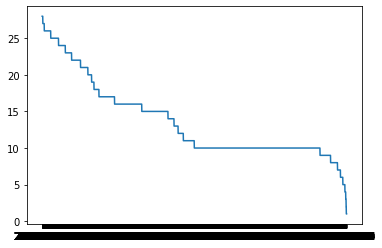

In [4]:
dftwo = df_data['Data_Venda'].value_counts().rename_axis('Data_Venda').reset_index(name='counts')
dftwo['Data_Venda'] = dftwo['Data_Venda'].astype(str)


x=dftwo['Data_Venda']
y=dftwo['counts']
plt.plot(x,y)
plt.plot()

In [5]:
pu = df_data['Quantidade']
# será se deve ser essas colunas mesmo?
df_features = df_data.drop(columns=['Tipo_Titulo', 'Vencimento_do_Titulo', 'Data_Venda', 'Quantidade'])

df_features

,PU,Valor
0,1655.206735,63890.97
1,1480.154343,845168.12
2,870.303177,246469.85
3,936.285273,27339.52
4,808.587250,397663.20
...,...,...
66164,960.339019,105829.35
66165,1672.613421,453612.75
66166,1677.517573,147957.04
66167,946.566666,567.93


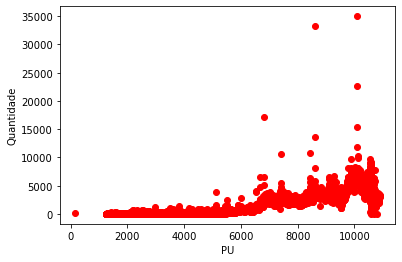

In [6]:
#df_datapu = [x for i, x  in enumerate(df_data['PU']) if i < 1000]
#df_dataqtd = [x for i, x  in enumerate(df_data['Quantidade']) if i < 1000]

#plt.scatter(df_datapu, df_dataqtd)
df_dados_c0=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado com Juros Semestrais']
df_dados_c1=df_data[df_data['Tipo_Titulo']=='Tesouro Selic']
df_dados_c2=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado']
df_dados_c3=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+']
df_dados_c4=df_data[df_data['Tipo_Titulo']=='Tesouro IGPM+ com Juros Semestrais']
df_dados_c5=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+ com Juros Semestrais']

#plt.scatter(df_dados_c0['PU'], df_dados_c0['Quantidade'],c='blue')
plt.scatter(df_dados_c1['PU'], df_dados_c1['Quantidade'],c='red')
#plt.scatter(df_dados_c2['PU'], df_dados_c2['Quantidade'],c='green')
#plt.scatter(df_dados_c3['PU'], df_dados_c3['Quantidade'],c='purple')
#plt.scatter(df_dados_c4['PU'], df_dados_c4['Quantidade'],c='yellow')
#plt.scatter(df_dados_c5['PU'], df_dados_c5['Quantidade'],c='red')


plt.xlabel('PU')
plt.ylabel('Quantidade')
# pode-se observar que quanto menor o preço unitário, maior é a quantidade vendida
plt.show()

In [7]:
df_features_c1=df_dados_c1.drop(columns=['Tipo_Titulo','Data_Venda','Vencimento_do_Titulo'])
df_features_c1_datas = df_dados_c1.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo'])
df_features_c1

,PU,Quantidade,Valor
6,3694.700000,83.2,307399.04
9,3692.770059,133.6,493354.07
27,3728.658416,140.2,522757.90
32,3726.728894,39.8,148323.80
47,3730.540024,409.0,1525790.86
...,...,...,...
66128,3534.769820,100.4,354890.88
66138,3566.330371,75.4,268901.30
66144,3567.210000,76.0,271107.96
66162,3568.050000,175.4,625835.97


In [8]:
future_dates = df_features_c1_datas['Data_Venda']
first = min(df_features_c1_datas['Data_Venda'])
last = max(df_features_c1_datas['Data_Venda'])
diff = last - first
future_dates = future_dates + np.timedelta64(diff)
future_dates

6       2028-07-09
9       2028-07-09
27      2028-08-06
32      2028-08-06
47      2028-08-09
           ...    
66128   2028-03-03
66138   2028-03-30
66144   2028-03-30
66162   2028-03-31
66168   2028-03-31
Name: Data_Venda, Length: 7957, dtype: datetime64[ns]

In [9]:
# exemplo de filtro por intervalo de datas
def filter_interval (data_frame, min_dt, max_dt):
    min_date = np.datetime64(min_dt)
    max_date = np.datetime64(max_dt)
    filtered = [x for x in data_frame if x < max_date and x > min_date]
    return pd.DataFrame({'filtered': filtered})

def removable_indexes (data_frame, min_dt, max_dt):
    min_date = np.datetime64(min_dt)
    max_date = np.datetime64(max_dt)
    return [i for i, x in enumerate(data_frame) if x >= max_date or x <= min_date]

def remove_indexes (data_frame, indexes):
    return [x for i, x in enumerate(data_frame) if i not in indexes]

r = filter_interval(df_features_c1_datas['Data_Venda'], '2008-05-01', '2008-05-30')
r

,filtered
0,2008-05-23
1,2008-05-23
2,2008-05-15
3,2008-05-29
4,2008-05-29
5,2008-05-19
6,2008-05-19
7,2008-05-20
8,2008-05-20
9,2008-05-21


In [10]:
x1 = len(df_features_c1_datas['Data_Venda'])
x2 = len(df_features_c1['PU'])
if x1 != x2:
    raise Exception(f'{x1} is not equal to {x2}')

### Treinando modelo

In [11]:
def getModel():
    #return LinearRegression() # resultados menos efetivos, porém instantaneos e requer pouco processamento
    return RandomForestRegressor() # resultados melhores mas requer muito processamento

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_features.values, pu, test_size=0.2)
# pq está tão baixo?

model = getModel().fit(X_train, y_train)

score = model.score(X_test,y_test)

score

0.9721344197736057

In [13]:
#Tentando fazer o training com df_dados_c1(seriam os dados redimencionados para f1 e f2 dos tesouros de tipo Selic)
pu_selic=df_dados_c1['PU']
data_selic=df_dados_c1['Data_Venda']
X_train, X_test, y_train, y_test = train_test_split(df_features_c1.values, pu_selic, test_size=0.2)
model = getModel().fit(X_train, y_train)

score = model.score(X_test,y_test)

score

0.9999112720208198

In [14]:
model.predict(X_train)

array([2167.04896531, 5917.89728518, 3768.48883382, ..., 4188.93003991,
       4002.99868934, 1398.06994533])

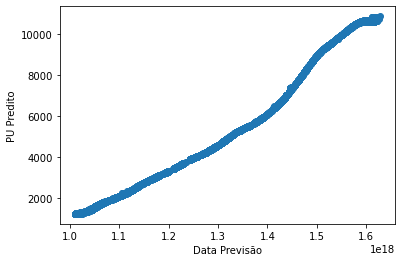

In [15]:
pû_selic = cross_val_predict(getModel(),df_features_c1.values,  pu_selic, cv = 20)
datâ_selic = cross_val_predict(getModel(),df_features_c1.values,  data_selic, cv = 20)
datas = df_dados_c1['Data_Venda']
plt.scatter(datâ_selic, pû_selic)

plt.xlabel('Data Previsão')
plt.ylabel('PU Predito')

plt.show()

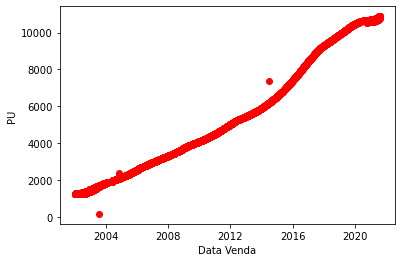

6365

In [16]:
plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')

plt.ylabel('PU')
plt.xlabel('Data Venda')
plt.show()
len(model.predict(X_train))

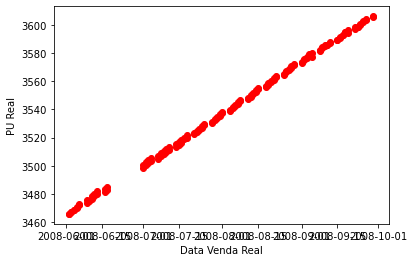

6365

In [17]:
min_date = '2008-06-01'
max_date = '2008-09-30'
filtered_sell_date = filter_interval(df_features_c1_datas['Data_Venda'], min_date, max_date)
pu_invalid_indexes = removable_indexes(df_features_c1_datas['Data_Venda'], min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(df_features_c1['PU'], pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Real')
plt.xlabel('Data Venda Real')
plt.show()
len(model.predict(X_train))

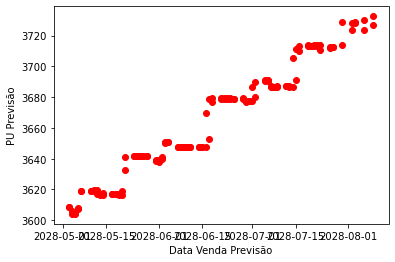

6365

In [18]:
min_date = '2028-05-01'
max_date = '2028-08-10'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))


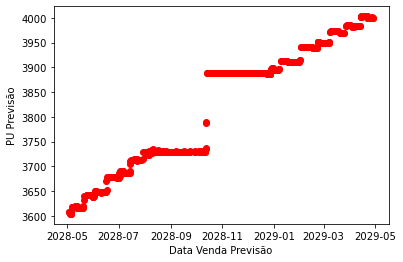

6365

In [19]:
min_date = '2028-05-01'
max_date = '2029-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

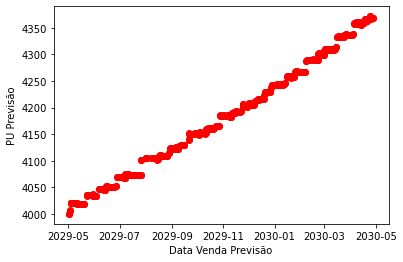

6365

In [20]:
min_date = '2029-05-01'
max_date = '2030-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

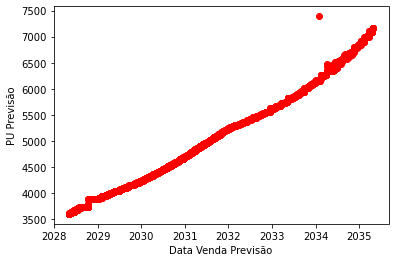

6365

In [21]:
min_date = '2028-05-01'
max_date = '2035-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

In [22]:
aux=df_data.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo','PU'])
data_Value_Per_Month=pd.DataFrame(aux.groupby(aux['Data_Venda'].dt.to_period('m'))['Valor'].sum())

data_Value_Per_Month

,Valor
Data_Venda,
2002-01,4.628261e+06
2002-02,7.682096e+06
2002-03,5.545423e+06
2002-04,4.148207e+06
2002-05,3.184792e+06
...,...
2021-04,2.171279e+09
2021-05,2.122832e+09
2021-06,2.341891e+09


### Validando dados

In [23]:
scores = cross_val_score(getModel(), df_features.values, pu, cv = 10)
# pq está tão baixo?
print('R2=',np.mean(scores))

R2= 0.9656593503046695


### Verificando correlação

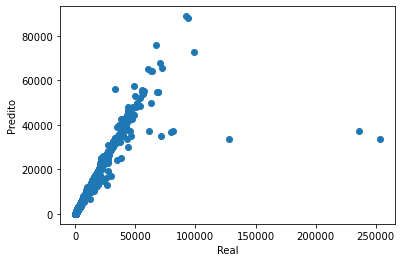

In [24]:
pû = cross_val_predict(getModel(), df_features.values, pu, cv = 20)
plt.scatter(pu, pû)

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()

In [25]:
pû_selic

array([3687.09755532, 3686.9316483 , 3730.38973922, ..., 3565.1933651 ,
       3566.19110939, 3571.41600538])

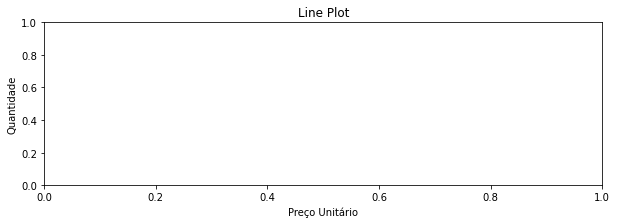

0        False
1        False
2        False
3        False
4        False
         ...  
66164    False
66165    False
66166    False
66167    False
66168     True
Name: Tipo_Titulo, Length: 66169, dtype: bool

In [26]:
fig=plt.figure(figsize=(10,3))
isSelic = df_data['Tipo_Titulo'] == "Tesouro Selic"
#if df_data.isSelic == true:
 #   plt.plot(df_data['PU'][isSelic],df_data['Quantidade'][isSelic])

plt.title('Line Plot')
plt.xlabel('Preço Unitário')
plt.ylabel('Quantidade')
#df_data['PU'][isSelic].value_counts()
plt.show()

isSelic

<AxesSubplot:title={'center':'Valor Total Mensal'}, xlabel='Data_Venda', ylabel='Valor'>

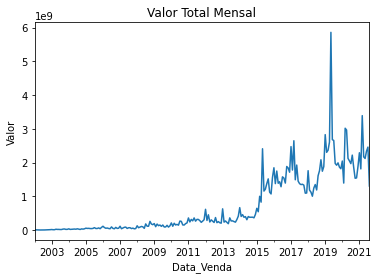

In [27]:
#Aqui temos a serie
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.title('Valor Total Mensal')

data_Value_Per_Month['Valor'].plot()

In [28]:
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Quantidade'])
aux.set_index('Data_Venda')
data_Value_Per_Month_Selic=pd.DataFrame(aux[aux['Tipo_Titulo']=='Tesouro Selic'].groupby(aux['Data_Venda'].dt.to_period('m'))['Valor'].sum())
data_Value_Per_Month_Selic

,Valor
Data_Venda,
2002-01,3.100259e+05
2002-02,2.901708e+05
2002-03,2.790547e+05
2002-04,4.540093e+05
2002-05,4.398695e+05
...,...
2021-04,7.922581e+08
2021-05,7.698618e+08
2021-06,1.003180e+09


<AxesSubplot:title={'center':'Valor Total Mensal(Selic)'}, xlabel='Data_Venda', ylabel='Valor'>

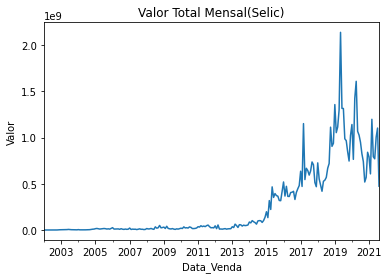

In [29]:
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.title('Valor Total Mensal(Selic)')

data_Value_Per_Month_Selic['Valor'].plot()

In [30]:
data_Value_Per_Month.index=data_Value_Per_Month.index.to_timestamp()

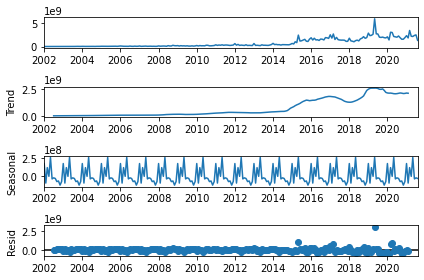

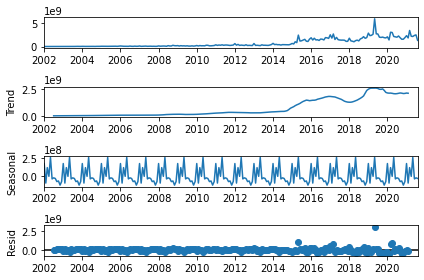

In [31]:
#Seasonal decompese nos da mais detalhes do comportamento da serie ao longo do tempos
result = seasonal_decompose(data_Value_Per_Month)
result.plot()
#Pode se ver que o dado e claramente afetado por estações,a trend esta agora apontando levemente para baixo

In [32]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_Value_Per_Month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10472.75741720308
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:9865.12908815546
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:9639.750965663738
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:9101.91141721591
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:9682.151153931753
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:9584.40034516649
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:9138.76405997884
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:9098.43534049096
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10305.78938500874
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:9753.29359145432
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:9554.082743890734
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:9004.36260060528
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:9806.209276844927
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:9706.408699028569
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:908

In [33]:
#Pegamos a configuração que deu o menor AIC (Akaike Information Critera)
mod = sm.tsa.statespace.SARIMAX(data_Value_Per_Month,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6036      0.048    -12.578      0.000      -0.698      -0.510
ma.S.L12      -0.8700      0.046    -18.863      0.000      -0.960      -0.780
sigma2      2.465e+17   8.86e-20   2.78e+36      0.000    2.46e+17    2.46e+17


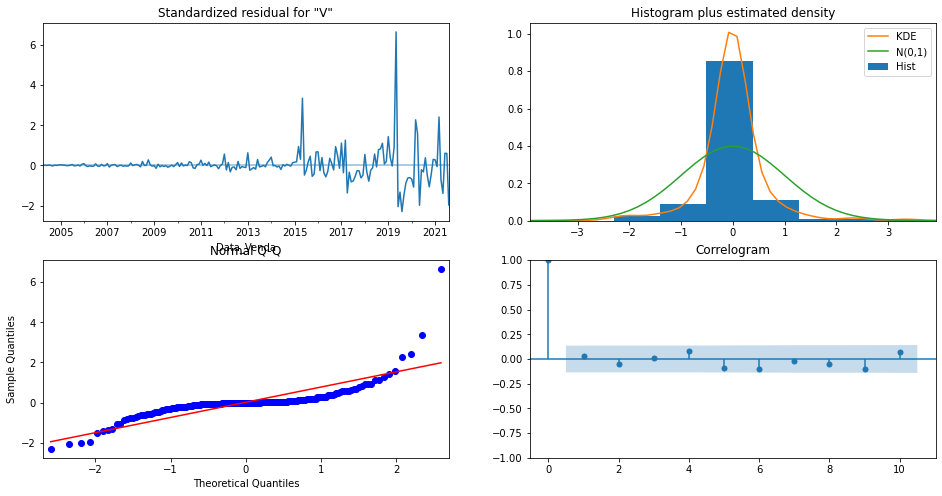

In [34]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

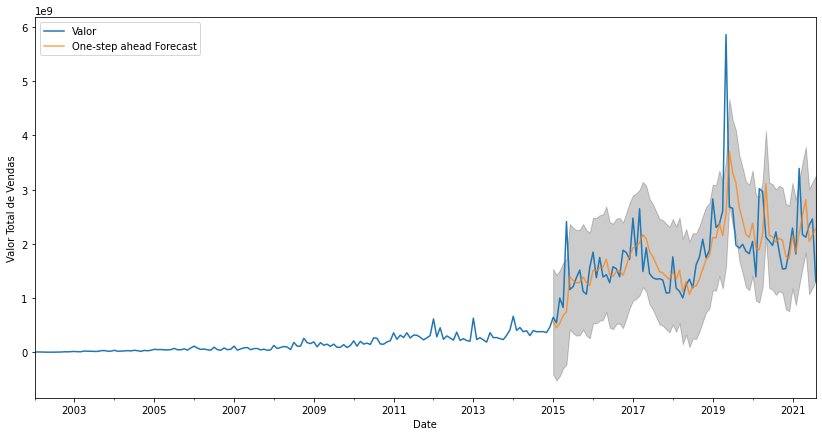

In [35]:
#Nesse grafico podemos ver prediçoes com o ARIMA
#No caso observando o nosso grafico o modelo começa a tentar preve a partir de janeiro de 2015 um mes a frente do real
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data_Value_Per_Month['2002':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Valor Total de Vendas')
plt.legend()
plt.show()

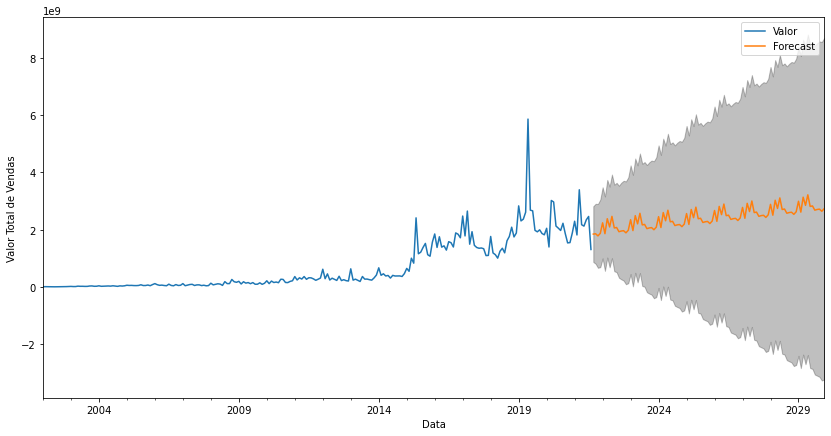

In [36]:
#Aqui temos uma predição de 100 meses no futuro
#A areá cinza conta como uma margem de erro imagino
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = data_Value_Per_Month.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Valor Total de Vendas')
plt.legend()
plt.show()
#Talves as vendas baixa antes de 2015 estejam enviezando?

In [52]:
aux=df_data.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo','PU'])
data_Value_Total=pd.DataFrame(aux.groupby(aux['Data_Venda'])['Valor'].sum())


sdate = date(2004,1,2)   # start date
edate = date(2021,8,12)   # end date
AllDates=pd.date_range(sdate,edate-timedelta(days=1),freq='d').to_frame()
AllDates=AllDates.rename(columns = {0:'Data_Venda'}, inplace = False)



data_Value_Total['Quantidade']=(aux.groupby(aux['Data_Venda'])['Quantidade'].sum())

data_Value_Total=pd.merge(data_Value_Total, AllDates, on='Data_Venda', how='right')

data_Value_Total=data_Value_Total.set_index('Data_Venda')

data_Value_Total['Dia_Semana'] = data_Value_Total.index.dayofweek
data_Value_Total['Dia'] = data_Value_Total.index.day
data_Value_Total['Mes'] = data_Value_Total.index.month
data_Value_Total['Ano'] = data_Value_Total.index.year

data_Value_Total['Quantidade'] = data_Value_Total['Quantidade'] .fillna(0)
data_Value_Total['Valor'] = data_Value_Total['Valor'] .fillna(0)

#AllDates
data_Value_Total


,Valor,Quantidade,Dia_Semana,Dia,Mes,Ano
Data_Venda,,,,,,
2004-01-02,1.501334e+06,1412.20,4,2,1,2004
2004-01-03,0.000000e+00,0.00,5,3,1,2004
2004-01-04,0.000000e+00,0.00,6,4,1,2004
2004-01-05,1.131753e+06,887.40,0,5,1,2004
2004-01-06,1.579074e+06,1299.60,1,6,1,2004
...,...,...,...,...,...,...
2021-08-07,0.000000e+00,0.00,5,7,8,2021
2021-08-08,0.000000e+00,0.00,6,8,8,2021
2021-08-09,1.803391e+08,76157.59,0,9,8,2021


<AxesSubplot:title={'center':'Valor Total Dias'}, xlabel='Data_Venda', ylabel='Valor'>

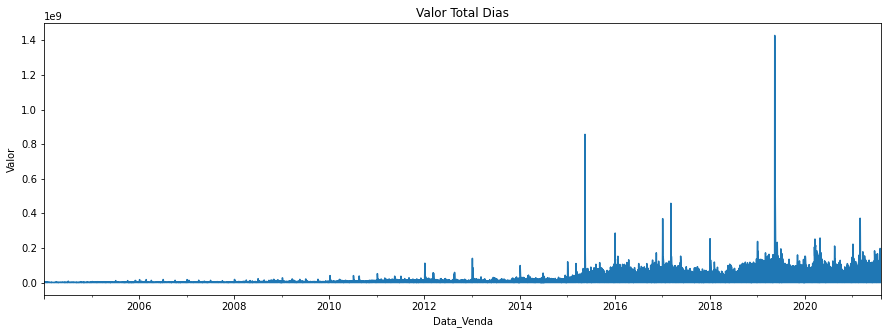

In [53]:
plt.figure(figsize=(15,5))
plt.xlabel('Data_Venda')
plt.ylabel('Valor')
plt.title('Valor Total Dias')
#plt.xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))

data_Value_Total['Valor'].plot()

<AxesSubplot:title={'center':'Valor Total Dias'}, xlabel='Data_Venda', ylabel='Valor'>

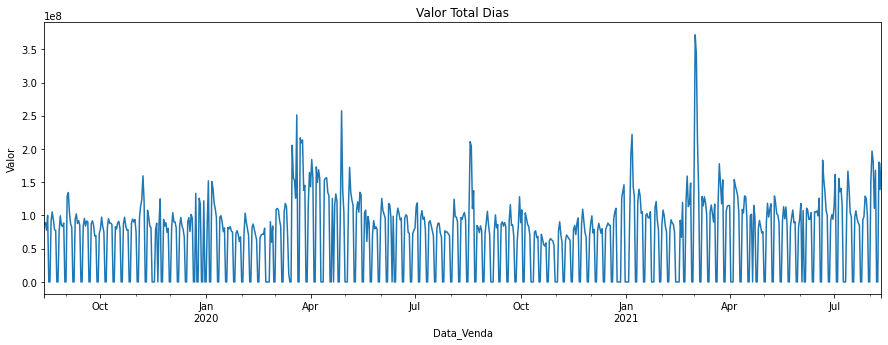

In [54]:

#after_start_date = data_Value_Total['Data_Venda'] >= start_date
#before_end_date = data_Value_Total['Data_Venda'] <= end_date
#between_two_dates = after_start_date & before_end_date
filtered_dates = data_Value_Total.loc['2019-08-13':'2021-08-12']

filtered_dates

plt.figure(figsize=(15,5))
plt.xlabel('Data_Venda')
plt.ylabel('Valor')
plt.title('Valor Total Dias')
#plt.xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))

filtered_dates['Valor'].plot()

In [55]:
time_steps = 365  #TAMANHO DA JANELA
test_size = 365  #HORIZONTE DE PREVISÃO

train_size = int(len(data_Value_Total)-(test_size))
train, test = data_Value_Total.iloc[0:train_size], data_Value_Total.iloc[(train_size-time_steps):len(data_Value_Total)]
print(len(train), len(test))
test


6067 730


,Valor,Quantidade,Dia_Semana,Dia,Mes,Ano
Data_Venda,,,,,,
2019-08-13,8.670814e+07,37512.13,1,13,8,2019
2019-08-14,8.924035e+07,37714.88,2,14,8,2019
2019-08-15,7.803155e+07,32490.32,3,15,8,2019
2019-08-16,1.001342e+08,42592.38,4,16,8,2019
2019-08-17,0.000000e+00,0.00,5,17,8,2019
...,...,...,...,...,...,...
2021-08-07,0.000000e+00,0.00,5,7,8,2021
2021-08-08,0.000000e+00,0.00,6,8,8,2021
2021-08-09,1.803391e+08,76157.59,0,9,8,2021


In [56]:
def getModel():
    
    #return LinearRegression()
    #return DecisionTreeRegressor()
    return RandomForestRegressor(n_jobs=mp.cpu_count())

In [57]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    X.info()
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        v = np.append(v,X.iloc[i + time_steps,1])#Valor
        v = np.append(v,X.iloc[i + time_steps,2])#dia_semana
        v = np.append(v,X.iloc[i + time_steps,3])#dia
        v = np.append(v,X.iloc[i + time_steps,4])#mes
        v = np.append(v,X.iloc[i + time_steps,5])#ano
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['Valor'], time_steps)
X_test, y_test = create_dataset(test, test['Valor'], time_steps)

print(len(X_train), len(X_test))

X_train[0]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6067 entries, 2004-01-02 to 2020-08-11
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Valor       6067 non-null   float64
 1   Quantidade  6067 non-null   float64
 2   Dia_Semana  6067 non-null   int64  
 3   Dia         6067 non-null   int64  
 4   Mes         6067 non-null   int64  
 5   Ano         6067 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 331.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2019-08-13 to 2021-08-11
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Valor       730 non-null    float64
 1   Quantidade  730 non-null    float64
 2   Dia_Semana  730 non-null    int64  
 3   Dia         730 non-null    int64  
 4   Mes         730 non-null    int64  
 5   Ano         730 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 39

array([1.50133367e+06, 0.00000000e+00, 0.00000000e+00, 1.13175293e+06,
       1.57907401e+06, 1.30274572e+06, 4.30485103e+06, 3.62789318e+06,
       0.00000000e+00, 0.00000000e+00, 3.49967045e+06, 2.00170467e+06,
       1.26354040e+06, 1.46398142e+06, 9.84135990e+05, 0.00000000e+00,
       0.00000000e+00, 1.20481464e+06, 1.47868730e+06, 8.50567230e+05,
       2.53222950e+06, 2.25955771e+06, 0.00000000e+00, 0.00000000e+00,
       1.37992272e+06, 1.21999716e+06, 2.17479777e+06, 5.90595240e+05,
       1.32238772e+06, 0.00000000e+00, 0.00000000e+00, 1.37990032e+06,
       1.11543851e+06, 1.08930184e+06, 1.80613600e+06, 1.28111851e+06,
       0.00000000e+00, 0.00000000e+00, 1.41596520e+06, 1.21827363e+06,
       1.09550719e+06, 7.84608020e+05, 8.09929960e+05, 0.00000000e+00,
       0.00000000e+00, 1.63415301e+06, 1.06892012e+06, 1.16304303e+06,
       1.01254799e+06, 8.65562560e+05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.56856307e+06, 7.04151580e+05,
      

In [58]:
model = getModel().fit(X_train,y_train)

In [59]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 12,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [60]:
preds = []

base_teste = np.copy(X_test)

for i in range(len(base_teste)):
    y_pred = model.predict(np.array([base_teste[i]]))[0]

    preds.append(y_pred)
    
    for k in range(len(preds)):
        
        if i<len(base_teste):
            if k < time_steps:
                if(i<len(base_teste)-1):
                    base_teste[i+1][(time_steps-1)-k] = preds[(len(preds)-1)-k]

preds

[117421654.00960001,
 143851863.57100007,
 116425068.84109996,
 0.0,
 0.0,
 130872956.83559997,
 191597192.65889996,
 182581827.5638999,
 110476745.19750004,
 160773700.92040002,
 0.0,
 0.0,
 87901381.6862,
 81118434.65900001,
 78474851.17830001,
 101200668.26640001,
 88224484.09899998,
 0.0,
 0.0,
 82904752.66059999,
 84182256.8388,
 104600836.00819996,
 81288214.21039999,
 76528420.51619998,
 0.0,
 0.0,
 0.0,
 80073680.84879994,
 96559110.48190004,
 82304917.36489998,
 96146469.66509998,
 0.0,
 0.0,
 99169689.68429999,
 87899408.70100002,
 86968240.14730002,
 94445929.59619999,
 98118537.47830003,
 0.0,
 0.0,
 101055657.60059999,
 161803004.60519993,
 110367866.7046,
 116787098.99359994,
 88354912.6276,
 0.0,
 0.0,
 82447022.37130001,
 145651739.53200004,
 172667955.2709999,
 119993997.87280001,
 153553931.28490007,
 0.0,
 0.0,
 150933129.46699995,
 149893765.24019995,
 124524405.06849998,
 125933804.33239998,
 108460221.19389991,
 0.0,
 0.0,
 0.0,
 103193906.43270004,
 102109316.127

In [61]:
dados_real = data_Value_Total.iloc[(train_size):len(data_Value_Total),0].to_numpy()

len(dados_real)

df_real_predito = pd.DataFrame({'real':dados_real,'predito':preds})

df_real_predito

,real,predito
0,1.005398e+08,1.174217e+08
1,1.044744e+08,1.438519e+08
2,9.357352e+07,1.164251e+08
3,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00
...,...,...
360,0.000000e+00,0.000000e+00
361,0.000000e+00,0.000000e+00
362,1.803391e+08,1.660178e+08
363,1.390132e+08,1.315803e+08


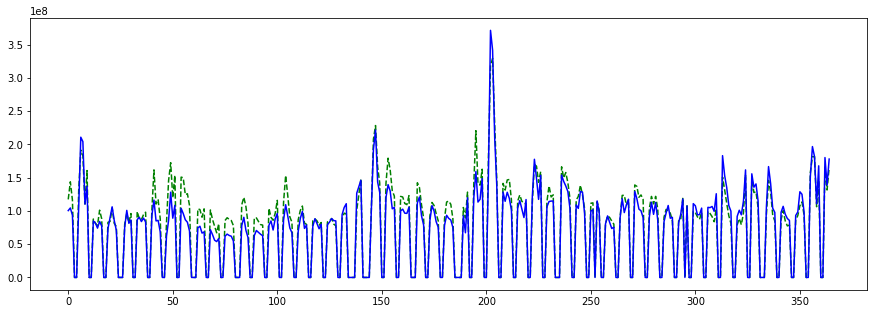

In [62]:
plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,30)
plt.show()

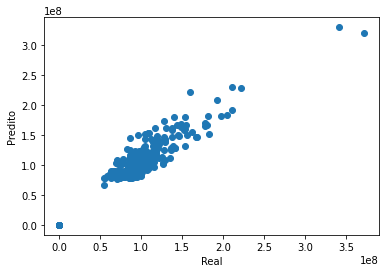

rmse= 15696802.442536877
mae= 10372473.07537808
r2= 0.928602665590811


In [63]:
plt.scatter(df_real_predito['real'],df_real_predito['predito'])

plt.xlabel('Real')
plt.ylabel('Predito')
#plt.xlim(0,10)

plt.show()

print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))
#print('mape=',mean_absolute_percentage_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))